# Air Quality Sensor Calibration

This notebook demonstrates the calibration of a lower-end sensor against a high-end reference sensor using linear regression. 
The following steps are covered:

1. Reading data from CSV files.
2. Preparing and merging datasets.
3. Performing linear regression.
4. Visualizing the results.

This process helps to establish a mathematical relationship between two sensors to calibrate the lower-end sensor's measurements.

In [75]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plots
sns.set(style='whitegrid')

## Step 1: Load the datasets

Here, we load two datasets:
1. High-end sensor data (`high_end_sensor_data.csv`)
2. Lower-end sensor data (`sensor_data.csv`)

Both datasets should have a common column (e.g., 'PM10') for calibration.

In [76]:
sensor_file_path = '../datasets/Team_01.csv'
sensor_data = pd.read_csv(sensor_file_path)
print(sensor_data.head())

# High-end sensor data
high_end_sensor_file_path = '../datasets/Aero_IoT_Workshop_Batch_4.csv'
high_end_sensor= pd.read_csv(high_end_sensor_file_path)
print(high_end_sensor.head())

                  created_at  entry_id  Temperature  RH  PM2.5   PM10
0  2025-01-01 17:30:21 +0530        56          NaN NaN   52.5  145.6
1  2025-01-01 17:30:45 +0530        57          NaN NaN   54.9  152.7
2  2025-01-01 17:31:08 +0530        58          NaN NaN   53.0  148.3
3  2025-01-01 17:31:30 +0530        59          NaN NaN   51.7  131.0
4  2025-01-01 17:31:53 +0530        60          NaN NaN   52.2  138.1
           Date Time   Monitor ID   Location ID   PM10(ppm)   PM2.5(ppm)
0  01 Jan 2025 17:31            2             1       0.194        0.083
1  01 Jan 2025 17:32            2             1       0.186        0.085
2  01 Jan 2025 17:33            2             1       0.184        0.085
3  01 Jan 2025 17:34            2             1       0.199        0.084
4  01 Jan 2025 17:35            2             1       0.179        0.084


In [77]:
sensor_data_2_path = '../datasets/Team_02.csv'
sensor_data_2 = pd.read_csv(sensor_data_2_path)

sensor_data_3_path = '../datasets/Team_03.csv'
sensor_data_3 = pd.read_csv(sensor_data_3_path)

## Step 2: Validate and Merge Datasets

Before merging, ensure the required column exists in both datasets. After validation, merge the data.

In [78]:
# Convert the 'created_at' column to datetime format
sensor_data['created_at'] = pd.to_datetime(sensor_data['created_at'])

# Format the 'created_at' column to the desired format
sensor_data['created_at'] = sensor_data['created_at'].dt.strftime('%d %b %Y %H:%M')
print(sensor_data.head(10))
sensor_data.info()


# Group by 'created_at' and calculate the mean for 'PM2.5' and 'PM10'
sensor_data = sensor_data.groupby('created_at')[['PM2.5', 'PM10']].mean().reset_index()

# Display the first few rows of the DataFrame
print(sensor_data.head(10))


          created_at  entry_id  Temperature  RH  PM2.5   PM10
0  01 Jan 2025 17:30        56          NaN NaN   52.5  145.6
1  01 Jan 2025 17:30        57          NaN NaN   54.9  152.7
2  01 Jan 2025 17:31        58          NaN NaN   53.0  148.3
3  01 Jan 2025 17:31        59          NaN NaN   51.7  131.0
4  01 Jan 2025 17:31        60          NaN NaN   52.2  138.1
5  01 Jan 2025 17:32        61          NaN NaN   53.7  144.1
6  01 Jan 2025 17:32        62          NaN NaN   52.2  141.6
7  01 Jan 2025 17:33        63          NaN NaN   52.6  137.5
8  01 Jan 2025 17:33        64          NaN NaN   55.0  148.7
9  01 Jan 2025 17:33        65          NaN NaN   56.7  153.1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5815 entries, 0 to 5814
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   created_at   5815 non-null   object 
 1   entry_id     5815 non-null   int64  
 2   Temperature  0 non-null      float64
 3

In [79]:
high_end_sensor= high_end_sensor.drop_duplicates(subset='Date Time')
high_end_sensor.head()
high_end_sensor.info()

print(high_end_sensor.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2826 entries, 0 to 2825
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date Time     2826 non-null   object 
 1    Monitor ID   2826 non-null   int64  
 2    Location ID  2826 non-null   int64  
 3    PM10(ppm)    2826 non-null   float64
 4    PM2.5(ppm)   2826 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 110.5+ KB
Index(['Date Time', ' Monitor ID', ' Location ID', ' PM10(ppm)',
       ' PM2.5(ppm)'],
      dtype='object')


In [80]:
# Rename the 'Date Time' column in high_end_sensor to match 'created_at' in sensor_data
high_end_sensor = high_end_sensor.rename(columns={'Date Time': 'created_at'})

# Select only the 'created_at', 'PM10(ppm)', and 'PM2.5(ppm)' columns from high_end_sensor
high_end_sensor_selected = high_end_sensor[['created_at', ' PM10(ppm)', ' PM2.5(ppm)']].copy()

#Convert PM2.5 and PM10 from ppm to ppb
high_end_sensor_selected.loc[:, ' PM10(ppm)'] = high_end_sensor_selected[' PM10(ppm)'] * 1000
high_end_sensor_selected.loc[:, ' PM2.5(ppm)'] = high_end_sensor_selected[' PM2.5(ppm)'] * 1000

# Rename the columns 
high_end_sensor_selected.rename(columns={' PM10(ppm)': 'PM10_highend', ' PM2.5(ppm)': 'PM2.5_highend'}, inplace=True)

# Merge the datasets on 'created_at' column
merged_data = pd.merge(sensor_data, high_end_sensor_selected, on='created_at', how='inner')

merged_data.head()
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2210 entries, 0 to 2209
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   created_at     2210 non-null   object 
 1   PM2.5          2210 non-null   float64
 2   PM10           2210 non-null   float64
 3   PM10_highend   2210 non-null   float64
 4   PM2.5_highend  2210 non-null   float64
dtypes: float64(4), object(1)
memory usage: 86.5+ KB


In [81]:
# Drop rows with any null values
merged_data = merged_data.dropna()
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2210 entries, 0 to 2209
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   created_at     2210 non-null   object 
 1   PM2.5          2210 non-null   float64
 2   PM10           2210 non-null   float64
 3   PM10_highend   2210 non-null   float64
 4   PM2.5_highend  2210 non-null   float64
dtypes: float64(4), object(1)
memory usage: 86.5+ KB


In [82]:
# Define file names and column name
column_name = 'PM10'

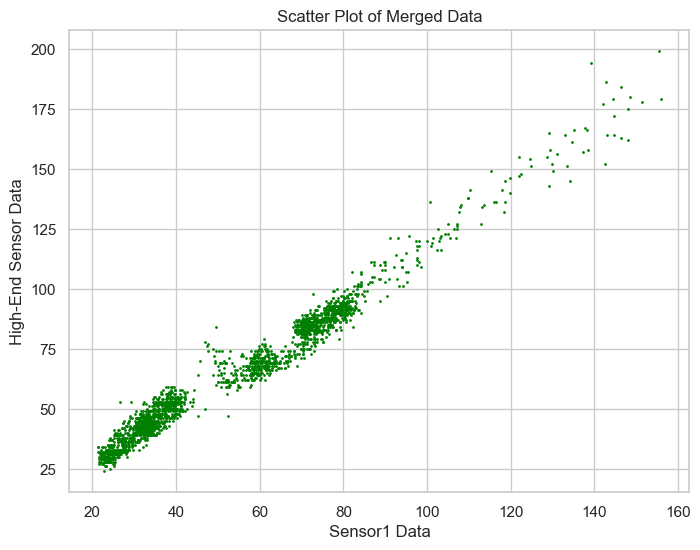

In [83]:
# Scatter plot of the merged data
plt.figure(figsize=(8, 6))
plt.scatter(merged_data[f'{column_name}'], merged_data[f'{column_name}_highend'], color='green',s=1)
plt.xlabel('Sensor1 Data')
plt.ylabel('High-End Sensor Data')
plt.title('Scatter Plot of Merged Data')
plt.show()

## Step 3: Perform Linear Regression

Using the lower-end sensor data as the independent variable (X) and the high-end sensor data as the dependent variable (y), 
we fit a linear regression model.

In [84]:
# Extract relevant columns for regression
X = merged_data[[f'{column_name}']].values  # Sensor1 data
y = merged_data[f'{column_name}_highend'].values       # High-end sensor data

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the coefficient and intercept
coefficient = model.coef_[0]
intercept = model.intercept_

# Print the results
print(f'Coefficient: {coefficient}')
print(f'Intercept: {intercept}')

Coefficient: 1.0877036821737174
Intercept: 6.509110756054774


### Other Regression Models

In addition to the standard linear regression model, we also explore **Ridge** and **Lasso** regression models. These models are useful when dealing with multicollinearity or when we want to perform feature selection.

#### Ridge Regression
Ridge regression adds a penalty equal to the square of the magnitude of the coefficients to the loss function. This penalty term helps shrink the coefficients, thus reducing model complexity and preventing overfitting.

The Ridge regression model equation is:

$$
y = \beta_0 + \beta_1 X + \lambda \sum_{i=1}^{n} \beta_i^2
$$

Where:
- \( \beta_0 \): Intercept
- \( \beta_1 \): Coefficient
- \( \lambda \): Regularization parameter

In [85]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# Ridge Regression
ridge_model = Ridge()
ridge_model.fit(X, y)

# Get the coefficient, intercept, and regularization parameter
ridge_coefficient = ridge_model.coef_[0]
ridge_intercept = ridge_model.intercept_
ridge_alpha = ridge_model.alpha

# Print the first 5 predictions
ridge_predictions = ridge_model.predict(X)
print('Ridge Regression Predictions (first 5):', ridge_predictions[:5])

# Print the coefficients, intercept, and regularization parameter
print(f'Ridge Coefficient: {ridge_coefficient}')
print(f'Ridge Intercept: {ridge_intercept}')
print(f'Ridge Regularization Parameter (alpha): {ridge_alpha}')

# Display the equation for the Ridge regression model
print(f'Ridge Regression Model Equation: y = {ridge_coefficient} * X + {ridge_intercept}')


Ridge Regression Predictions (first 5): [157.84487879 161.88750774 165.78510965 175.53817861 176.19080032]
Ridge Coefficient: 1.0877028580203139
Ridge Intercept: 6.509154473601477
Ridge Regularization Parameter (alpha): 1.0
Ridge Regression Model Equation: y = 1.0877028580203139 * X + 6.509154473601477



#### Lasso Regression
Lasso regression adds a penalty equal to the absolute value of the magnitude of the coefficients to the loss function. This penalty term can shrink some coefficients to zero, effectively performing feature selection.

The Lasso regression model equation is:

$$
y = \beta_0 + \beta_1 X + \lambda \sum_{i=1}^{n} |\beta_i|
$$

Where:
- \( \beta_0 \): Intercept
- \( \beta_1 \): Coefficient
- \( \lambda \): Regularization parameter


In [86]:
# Lasso Regression
lasso_model = Lasso()
lasso_model.fit(X, y)

# Get the coefficient, intercept, and regularization parameter
lasso_coefficient = lasso_model.coef_[0]
lasso_intercept = lasso_model.intercept_
lasso_alpha = lasso_model.alpha

# Print the first 5 predictions
lasso_predictions = lasso_model.predict(X)
print('Lasso Regression Predictions (first 5):', lasso_predictions[:5])

# Print the coefficients, intercept, and regularization parameter
print(f'Lasso Coefficient: {lasso_coefficient}')
print(f'Lasso Intercept: {lasso_intercept}')
print(f'Lasso Regularization Parameter (alpha): {lasso_alpha}')

# Display the equation for the Lasso regression model
print(f'Lasso Regression Model Equation: y = {lasso_coefficient} * X + {lasso_intercept}')

Lasso Regression Predictions (first 5): [157.70079386 161.73720225 165.62880675 175.36686825 176.01848575]
Lasso Coefficient: 1.086029163252158
Lasso Intercept: 6.597936281551327
Lasso Regularization Parameter (alpha): 1.0
Lasso Regression Model Equation: y = 1.086029163252158 * X + 6.597936281551327



#### Benefits of Ridge and Lasso Regression
Both Ridge and Lasso regression models help improve the generalization of the model by adding a regularization term to the loss function:
- **Ridge**: Reduces model complexity by shrinking coefficients but does not perform feature selection.
- **Lasso**: Performs feature selection by shrinking some coefficients to zero.


## Step 4: Visualize Results

The scatter plot below shows the raw data points (blue dots). The red line represents the regression line fit to the data.

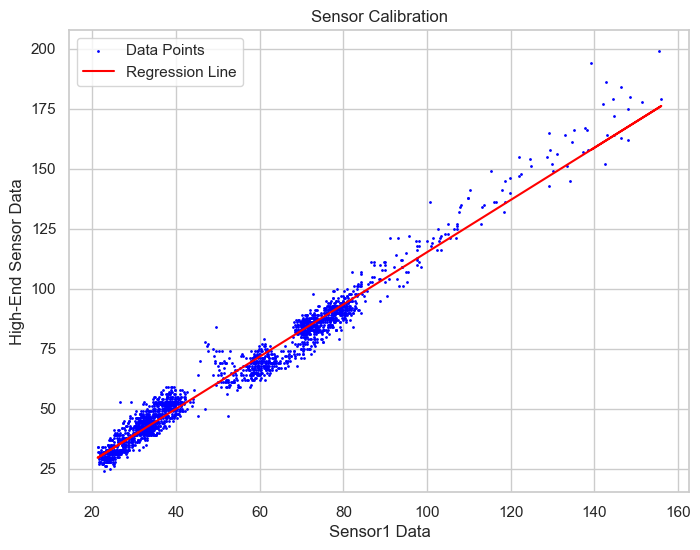

In [87]:
# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', label='Data Points', s=1)
plt.plot(X, model.predict(X), color='red', label='Regression Line')
plt.xlabel('Sensor1 Data')
plt.ylabel('High-End Sensor Data')
plt.title('Sensor Calibration')
plt.legend()
plt.show()

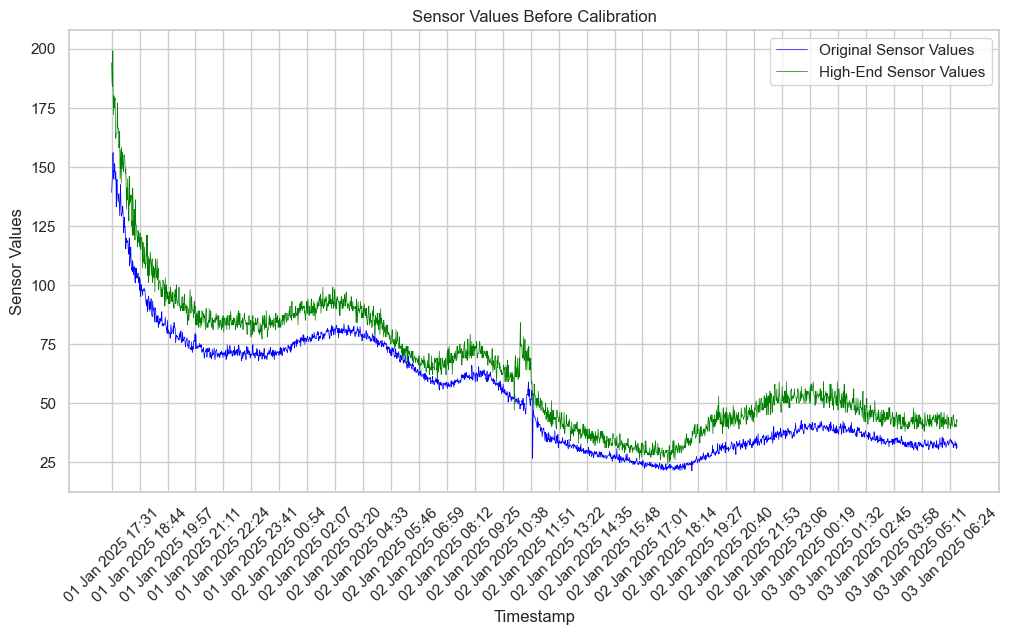

In [88]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot the original sensor values as lines
plt.plot(merged_data['created_at'], merged_data[f'{column_name}'], color='blue', label='Original Sensor Values', linewidth=0.5)

# Plot the high-end sensor values as lines
plt.plot(merged_data['created_at'], merged_data[f'{column_name}_highend'], color='green', label='High-End Sensor Values', linewidth=0.5)

plt.xlabel('Timestamp')
plt.ylabel('Sensor Values')
plt.title('Sensor Values Before Calibration')
plt.legend()

# Improve the readability of the x-axis
plt.xticks(ticks=range(0, len(merged_data), len(merged_data)//30), rotation=45)
plt.show()


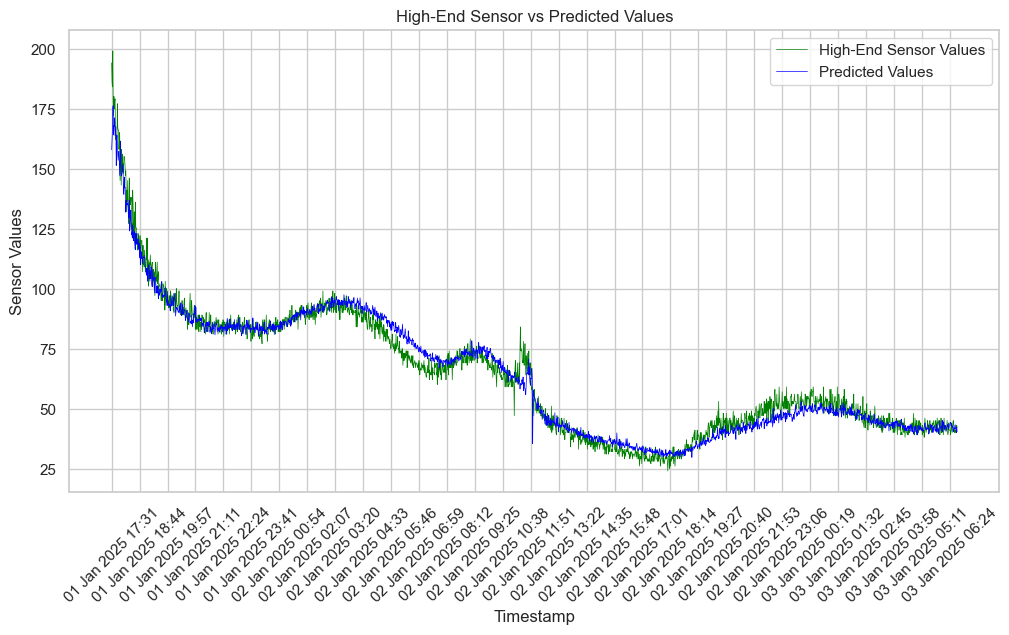

In [89]:
# Plot the results
plt.figure(figsize=(12, 6))

# Scatter plot of the high-end sensor values
plt.plot(merged_data['created_at'], merged_data[f'{column_name}_highend'], color='green', label='High-End Sensor Values', linewidth=0.5)

# Plot the predicted values
plt.plot(merged_data['created_at'], linear_predictions, color='blue', label='Predicted Values', linewidth=0.5)

plt.xlabel('Timestamp')
plt.ylabel('Sensor Values')
plt.title('High-End Sensor vs Predicted Values')
plt.legend()

# Improve the readability of the x-axis
plt.xticks(ticks=range(0, len(merged_data), len(merged_data)//30), rotation=45)
plt.show()


### Residuals Plot

Residuals are the differences between the observed and predicted values. A good model should have residuals randomly distributed around zero.

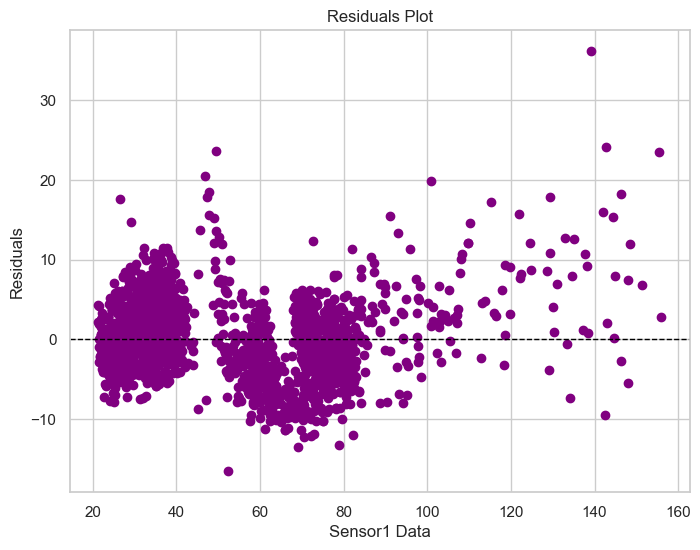

In [90]:
# Calculate residuals
residuals = y - model.predict(X)

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(X, residuals, color='purple')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Sensor1 Data')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

In [91]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions from the linear regression model
linear_predictions = model.predict(X)

# Calculate metrics for the linear regression model
mse = mean_squared_error(y, linear_predictions)
mae = mean_absolute_error(y, linear_predictions)
r2 = r2_score(y, linear_predictions)

print(f'Linear Regression Model Metrics:')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

Linear Regression Model Metrics:
Mean Squared Error (MSE): 21.374338931258357
Mean Absolute Error (MAE): 3.4912312777135517
R-squared (R2): 0.9706358206411886


In [92]:
# Calculate metrics for the linear regression model
linear_mse = mean_squared_error(y, linear_predictions)
linear_mae = mean_absolute_error(y, linear_predictions)
linear_r2 = r2_score(y, linear_predictions)

# Calculate metrics for the lasso regression model
lasso_mse = mean_squared_error(y, lasso_predictions)
lasso_mae = mean_absolute_error(y, lasso_predictions)
lasso_r2 = r2_score(y, lasso_predictions)

# Calculate metrics for the ridge regression model
ridge_mse = mean_squared_error(y, ridge_predictions)
ridge_mae = mean_absolute_error(y, ridge_predictions)
ridge_r2 = r2_score(y, ridge_predictions)

# Create a DataFrame to compare the metrics
metrics_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Lasso Regression', 'Ridge Regression'],
    'MSE': [linear_mse, lasso_mse, ridge_mse],
    'MAE': [linear_mae, lasso_mae, ridge_mae],
    'R2': [linear_r2, lasso_r2, ridge_r2]
})

# Display the metrics comparison
display(metrics_df)

# Determine the best performing model based on R2 score
best_model = metrics_df.loc[metrics_df['R2'].idxmax()]
print(f'Best Performing Model:\n{best_model}')

,Model,MSE,MAE,R2
0,Linear Regression,21.374339,3.491231,0.970636
1,Lasso Regression,21.376013,3.490089,0.970634
2,Ridge Regression,21.374339,3.491231,0.970636


Best Performing Model:
Model    Linear Regression
MSE              21.374339
MAE               3.491231
R2                0.970636
Name: 0, dtype: object
